In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from copy import deepcopy
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
from transformers import AutoTokenizer
import pandas as pd
import seaborn as sns
from datasets import Dataset
from os.path import join as oj
import pickle as pkl
import os
import dvu
dvu.set_style()
import analyze_utils

cols_output = ['final_answer_found',
               'final_model_queries', 'final_num_suffixes_checked']

Load results

In [11]:
# to delete
# dir_single_query = '/home/chansingh/mntv1/single_query_math_9_13'
# dir_suffix_search = '/home/chansingh/mntv1/anli_rough' # note: anli_rought was missnamed
# dir_suffix_search = '/home/chansingh/mntv1/suffix_math_9_12' # note: anli_rought was missnamed
# dir_suffix_search = '/home/chansingh/mntv1/suffix_math_9_13' # note: anli_rought was missnamed
# dir_suffix_search = '/home/chansingh/mntv1/suffix_math_9_14' # note: anli_rought was missnamed


# dir_single_query = '/home/chansingh/mntv1/single_query_math_9_15' # this has longer strings
dir_single_query = '/home/chansingh/mntv1/single_query_math_9_16'
# r = analyze_utils.load_results_and_cache(dir_single_query, save_file='r.pkl')
r_single_query = pd.read_pickle(os.path.join(dir_single_query, 'r.pkl'))
r_single_query = analyze_utils.postprocess_results(r_single_query)

# dir_suffix_search = '/home/chansingh/mntv1/suffix_math_9_15' # this has longer strings
dir_suffix_search = '/home/chansingh/mntv1/suffix_math_9_16'
# r_suffix_search = analyze_utils.load_results_and_cache(dir_suffix_search, save_file='r.pkl')
r_suffix_search = pd.read_pickle(os.path.join(dir_suffix_search, 'r.pkl'))
r_suffix_search = analyze_utils.postprocess_results(r_suffix_search)

# r = r_single_query
r = pd.concat((r_single_query, r_suffix_search)).sort_values('checkpoint')

Plot highly-summarized results

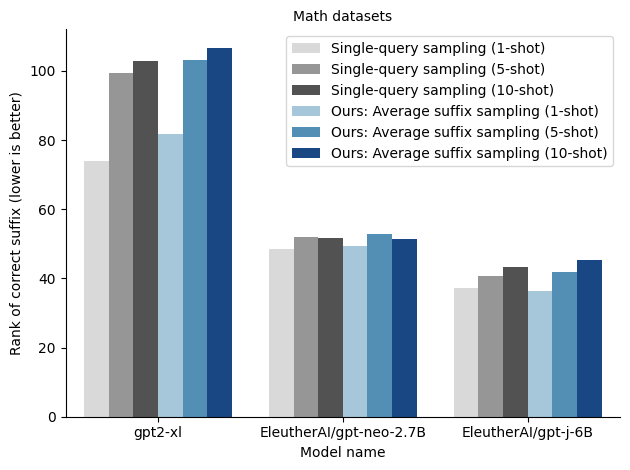

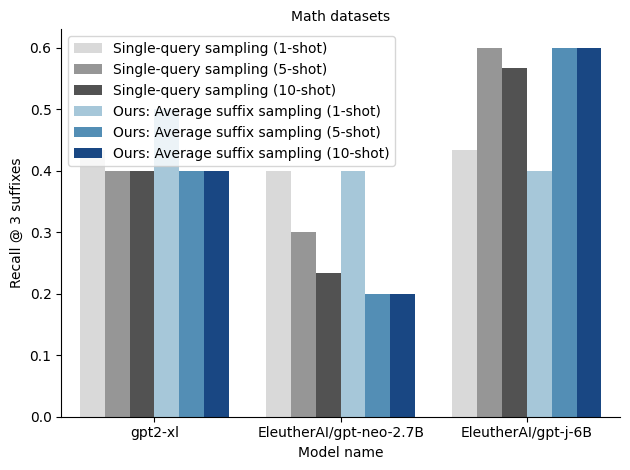

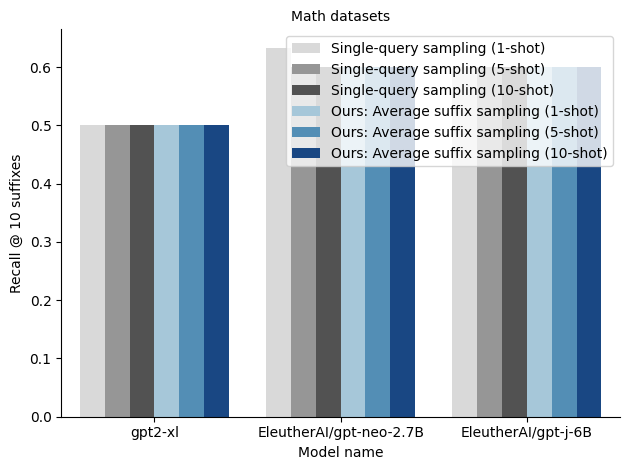

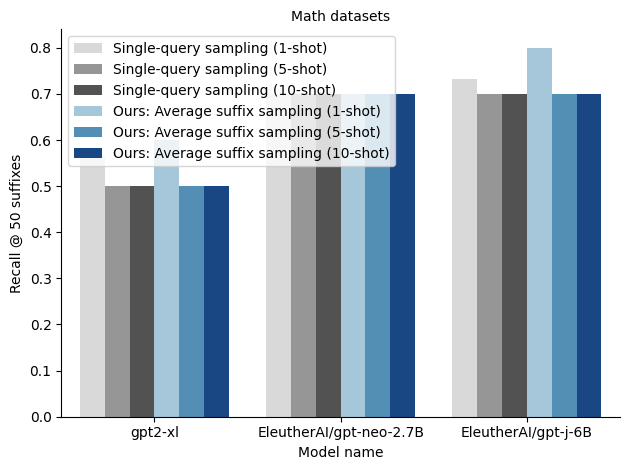

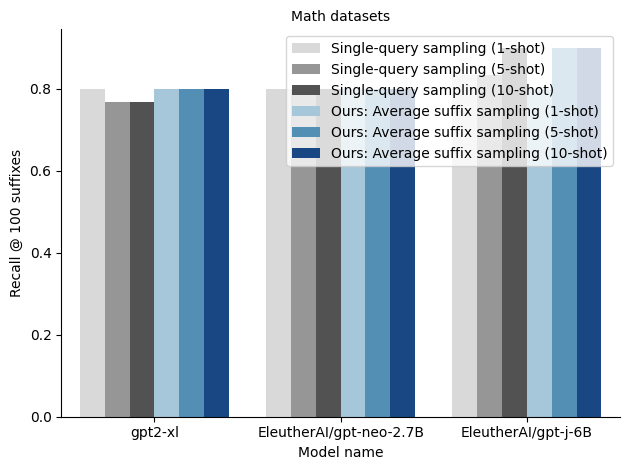

In [35]:
# rt = r[r.task_name.isin(['add_two', 'multiply_two', 'subtract_two'])]
rt = r
for metric_key in ['final_answer_pos_initial_token',
                   f'Recall @ {3} suffixes',
                #    f'Recall @ {10} suffixes', 
                #    f'Recall @ {50} suffixes', 
                #    f'Recall @ {100} suffixes', 
                   ]:
    tab = analyze_utils.num_suffixes_checked_tab(rt, metric_key=metric_key)
    analyze_utils.plot_tab(tab, metric_key=metric_key, title='Math datasets')


# look at some of the tables
Note, all `key_vars` must be stratified over in a plot.

In [46]:
# cols_to_view = r_single_query.columns # cols_to_view
key_vars = ['checkpoint', 'n_shots', 'use_single_query', 'task_name']
cols_to_view = [col for col in r_single_query.columns if col.startswith('final')]


with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    rg = r.groupby(key_vars)[cols_to_view].mean().round(2)
    # display(rg[rg['final_answer_found'] < 1.0])
    # display(rg)
# r.groupby(['template_num_init_string', 'use_single_query']).median().round(2)['final_model_queries'] # look at templates

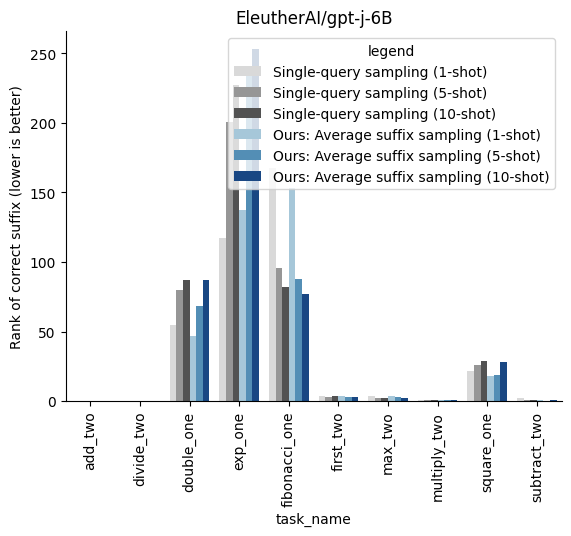

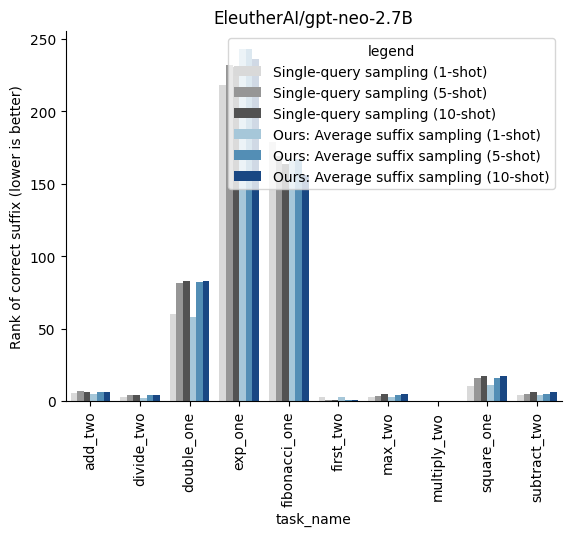

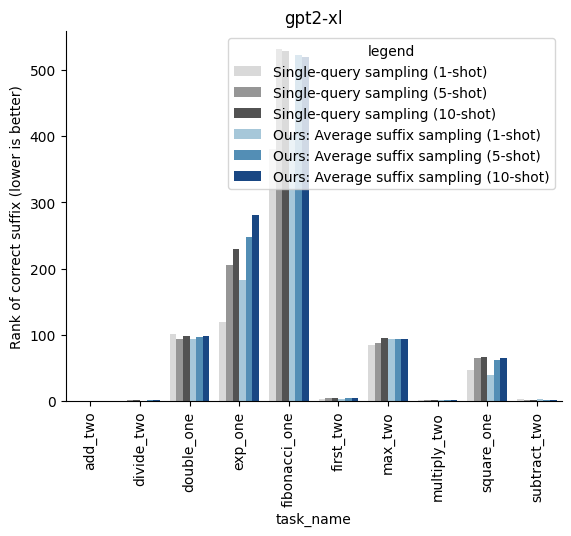

In [47]:
for checkpoint in rg.reset_index().checkpoint.unique():
    rp = rg.reset_index()
    # checkpoint = 'EleutherAI/gpt-j-6B'
    metric_key = 'final_answer_pos_initial_token'

    rp = rp[rp['checkpoint'] == checkpoint]
    rp['legend'] = rp['use_single_query'].map(
        analyze_utils.LEGEND_REMAP) + ' (' + rp['n_shots'].astype(str) + '-shot)'
    hue_order = analyze_utils.get_hue_order(rp['legend'])
    plt.title(checkpoint)
    sns.barplot(x='task_name', y=metric_key, hue_order=hue_order,
                hue='legend', data=rp, palette=analyze_utils.COLORS)  # data=tab[tab['n_shots'] == 1])
    plt.xticks(rotation='vertical')
    plt.ylabel(analyze_utils.YLABS.get(metric_key, metric_key))
    plt.show()

# convert to latex

In [9]:
rg = r_suffix_search.groupby(['checkpoint', 'n_shots', 'task_name'])
rg = rg[['final_model_queries','final_num_suffixes_checked']].mean().round(2) # mean over templates, task_name
print(rg.to_latex())

\begin{tabular}{lllrr}
\toprule
        &   &              &  final\_model\_queries &  final\_num\_suffixes\_checked \\
checkpoint & n\_shots & task\_name &                      &                             \\
\midrule
gpt2-large & 1 & add\_two &                 1.33 &                        5.67 \\
        &   & divide\_two &                 2.89 &                        8.67 \\
        &   & multiply\_two &                 3.89 &                       10.44 \\
gpt2-medium & 1 & add\_two &                 3.11 &                        8.44 \\
        &   & divide\_two &                 1.33 &                        5.44 \\
        &   & multiply\_two &                 1.33 &                        4.78 \\
gpt2-xl & 1 & add\_two &                 2.33 &                       12.11 \\
        &   & divide\_two &                 5.11 &                       18.78 \\
        &   & multiply\_two &                 1.33 &                        6.78 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_2765084/1313215481.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(rg.to_latex())
